In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

os.chdir("..")

In [2]:
import torch
from torch.distributions import Normal, Independent, Distribution, constraints, Transform, TransformedDistribution
from pyro.distributions import ConditionalDistribution

device = "cpu"
n_dim = 2



In [3]:
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical
rho = 0.95

V = np.array([
    [np.cos(np.pi/4), np.sin(np.pi/4)],
    [-np.sin(np.pi/4), np.cos(np.pi/4)]
]).T
D = np.array([
    [1+rho, 0],
    [0, 1-rho]
])

epsilon = 0.3

covariance = torch.FloatTensor(V @ D @ V.T)

mu_1 = torch.zeros(n_dim, 1, 2)
mu_1[:,:,0]=epsilon
mu_1[:,:,1]=-epsilon

mu_2 = torch.zeros(n_dim, 1, 2)
mu_2[:,:,0]=-epsilon
mu_2[:,:,1]=epsilon

loc = torch.cat([mu_1, mu_2],-2)

x_component_dist = Normal(
        loc[:,0],
        1
    )
p_x = MixtureSameFamily(
    Categorical(probs=torch.zeros(n_dim,2)+0.5),
    x_component_dist
)
component_dist = MultivariateNormal(
        loc,
        covariance.unsqueeze(0).unsqueeze(1)
    )

base_dist = MixtureSameFamily(
    Categorical(probs=torch.zeros(n_dim,2)+0.5), component_dist
)

In [4]:
(torch.FloatTensor(V)@loc).shape

torch.Size([2, 2, 2])

In [5]:
# epsilon = 0.5
# mu_1 = torch.zeros(n_dim, 1, 2)
# mu_1[:,:,0]=epsilon
# mu_1[:,:,1]=-epsilon
#
# mu_2 = torch.zeros(n_dim, 1, 2)
# mu_2[:,:,0]=-epsilon
# mu_2[:,:,1]=epsilon
#
#
# p_xy = MultivariateNormal(
#         torch.cat([mu_1, mu_2],-2),
#         covariance.unsqueeze(0).unsqueeze(1)
#     )

In [6]:


class FlipDiagonal(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = False

    def _call(self, x):
        x1, x2 = torch.chunk(x, 2, -1)
        mask = (x1 > x2).squeeze()
        x[mask] = torch.cat([x2, x1], -1)[mask]#torch.cat([x1, 2*x1-x2], -1)[mask]
        return x

    def _inverse(self, y):
        y1, y2 = torch.chunk(y, 2, -1)
        mask = torch.randint(0, 1, y1.shape).to(y1.device).squeeze() > 0
        y[mask] = torch.cat([y2, y1], -1)[mask]
        return y

    def log_abs_det_jacobian(self, x, y):
        return torch.log(torch.zeros(x.shape[:-1]) + 2)


p_xy = base_dist # TransformedDistribution(base_dist, [FlipDiagonal()])

In [7]:
base_dist.event_shape

torch.Size([2])

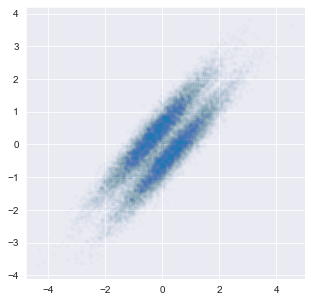

In [8]:
n_samples = 10000
res = 1000
M=6
xy = p_xy.sample([n_samples])

f, ax =plt.subplots(1,1, figsize=(5,5))

ax.plot(xy[:, :,0].view(-1).cpu(), xy[:, :, 1].view(-1).cpu(), '.', alpha=0.01)

# f, ax =plt.subplots(1,1, figsize=(5,5))
# P = base_dist.log_prob(torch.cat([
#     torch.linspace(-4,4,res).unsqueeze(1).unsqueeze(-1).repeat(1,res,1),
#     torch.linspace(-4,4,res).unsqueeze(0).unsqueeze(-1).repeat(res,1,1)
# ], -1).unsqueeze(-2)).data.numpy()
#
# X, Y = np.meshgrid(np.linspace(-4,4,res),np.linspace(-4,4,res))
#
# P[Y<X]= -100000
#
# plt.contourf(X,Y,P/10, levels=np.linspace(-6,1,6))
# plt.plot([-4,4],[-4,4],'-')

In [9]:
xy.shape

torch.Size([10000, 2, 2])

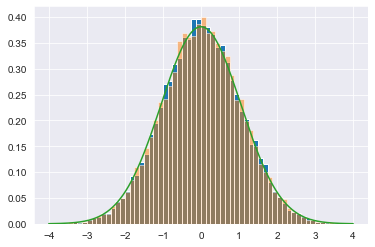

In [10]:
bins = 64
res = 1024

p_x_ = plt.hist(xy[:, :, 0].view(-1).cpu(), bins=bins, range=[-4,4], density=True)
plt.hist(xy[:, :, 1].view(-1).cpu(), alpha=0.5, bins=bins, range=[-4,4], density=True)
x = torch.linspace(-4,4, res)
plt.plot(x, p_x.log_prob(x.unsqueeze(1))[:,0].exp())

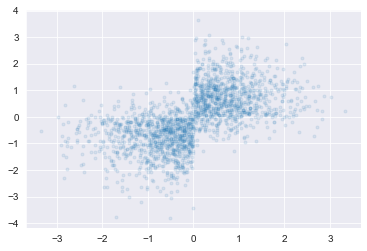

In [11]:
batch_size = 128
x, y = torch.chunk(p_xy.sample([1000]), 2, -1)
x = x.squeeze()
y = y.squeeze()

a = (x>0).long()

x_, y_ = torch.chunk(p_xy.sample([1000]), 2, -1)
x_ = x_.squeeze()
y_ = y_.squeeze()

a_ = (x_>0).long()
flip = (a+a_)==1
y_[flip] = -x_[flip]
x_[flip] = -y_[flip]
plt.plot(x.view(-1),y_.view(-1), '.', alpha=0.1)


In [12]:
x[a==0].shape

torch.Size([1031])

In [13]:
samples = p_xy.sample([10000])

h_xy = (-torch.logsumexp(component_dist.log_prob(samples.unsqueeze(-2)), -1).mean()+np.log(2))*n_dim
h_x = h_y = (-torch.logsumexp(x_component_dist.log_prob(samples[:,:,0].unsqueeze(-1)), -1).mean()+np.log(2))*n_dim
mi = h_x + h_y - h_xy
mi

tensor(1.2734)

In [14]:
samples = p_xy.sample([10000])
torch.logsumexp(x_component_dist.log_prob(samples[:,:,0].unsqueeze(-1)), -1).mean()

tensor(-0.7623)

In [15]:
torch.logsumexp(component_dist.log_prob(p_xy.sample([10000]).unsqueeze(-2)), -1).mean()+np.log(2)

tensor(-0.9148)

In [16]:
from core.models.mi_estimators import NWJ, JS, MINE, SMILE, InfoNCE, PrimalMutualInformationEstimator, PJS, PNWJ, PMINE, PSMILE, PInfoNCE
from core.models.ratio import JointRatioEstimator, SeparableRatioEstimator
from pyro.nn import DenseNN
from core.distributions import conditional_transformed_normal

In [33]:
hidden_dims = [256, 256]
mi_estimators = {
        'cpc': InfoNCE(
        ratio_estimator=SeparableRatioEstimator(
            f_x=DenseNN(
                input_dim=n_dim,
                hidden_dims=hidden_dims,
                param_dims=[n_dim]
            )
        )
    ),
    'pcpc': PInfoNCE(
        n_samples=32,
        r_y_x=conditional_transformed_normal(
            input_dim=n_dim,
            context_dim=n_dim,
            hidden_dims=hidden_dims,
        ),
        ratio_estimator=JointRatioEstimator(
            joint_net=DenseNN(
                input_dim=n_dim*2,
                hidden_dims=hidden_dims,
                param_dims=[1]
            )
        ),
        h_y=h_y
    ),
    # 'pnwj': PNWJ(
    #     r_y_x=conditional_transformed_normal(
    #         input_dim=n_dim,
    #         context_dim=n_dim,
    #         hidden_dims=hidden_dims,
    #     ),
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     ),
    #     h_y=h_y
    # ),
    # 'psmile': PSMILE(
    #     tau=1.0,
    #     r_y_x=conditional_transformed_normal(
    #         input_dim=n_dim,
    #         context_dim=n_dim,
    #         hidden_dims=hidden_dims,
    #     ),
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     ),
    #     h_y=h_y
    # ),
    # 'pmine': PMINE(
    #     r_y_x=conditional_transformed_normal(
    #         input_dim=n_dim,
    #         context_dim=n_dim,
    #         hidden_dims=hidden_dims,
    #     ),
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     ),
    #     h_y=h_y
    # ),
#     'pjs': PJS(
#     r_y_x=conditional_transformed_normal(
#         input_dim=n_dim,
#         context_dim=n_dim,
#         hidden_dims=hidden_dims,
#     ),
#     ratio_estimator=JointRatioEstimator(
#         joint_net=DenseNN(
#             input_dim=n_dim*2,
#             hidden_dims=hidden_dims,
#             param_dims=[1]
#         )
#     ),
#     h_y=h_y
# ),
#
#     'ba': PrimalMutualInformationEstimator(
#         r_y_x=conditional_transformed_normal(
#             input_dim=n_dim,
#             context_dim=n_dim,
#             hidden_dims=hidden_dims,
#         ),
#         h_y=h_y
#     ),
    # 'nwj': NWJ(
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     )
    # ),
    #
    # 'mine': MINE(
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     )
    # ),
    # 'smile': SMILE(
    #     tau=1.0,
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     )
    # ),
    # 'js': JS(
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     )
    # ),



}
mi_estimators

{'cpc': InfoNCE(
   (ratio_estimator): SeparableRatioEstimator(
   (f_x): DenseNN(
     (layers): ModuleList(
       (0): Linear(in_features=2, out_features=256, bias=True)
       (1): Linear(in_features=256, out_features=256, bias=True)
       (2): Linear(in_features=256, out_features=2, bias=True)
     )
     (f): ReLU()
   )
 )
   (baseline): BatchLogMeanExp()
 ),
 'pcpc': PInfoNCE(
   (ratio_estimator): JointRatioEstimator(
   (joint_net): DenseNN(
     (layers): ModuleList(
       (0): Linear(in_features=4, out_features=256, bias=True)
       (1): Linear(in_features=256, out_features=256, bias=True)
       (2): Linear(in_features=256, out_features=1, bias=True)
     )
     (f): ReLU()
   )
 )
   (r_y_x): ConditionalTransformedDistributionModule(
   (base_dist): ConstantParametrizedConditionalDistribution(
     (parametrization): ParametrizedNormal()
   )
   (transforms): ModuleList(
     (0): ConditionalLinear(
       (nn): DenseNN(
         (layers): ModuleList(
           (0): L

In [34]:
from tqdm.auto import tqdm
from torch.optim import Adam
import pandas as pd

iterations = 10000

results = []

for name, mi_estimator in mi_estimators.items():
    print(name)
    opt = Adam(mi_estimator.parameters(), lr=5e-4)

    for iteration in tqdm(range(iterations)):
        batch_size = 128
        x, y = torch.chunk(p_xy.sample([batch_size]), 2, -1)
        x = x.squeeze()
        y = y.squeeze()

        mi_value, mi_grad = mi_estimator(x, y)
        loss = -mi_grad

        opt.zero_grad()
        loss.backward()
        opt.step()
        results.append({
            "estimator": name,
            "iteration": iteration,
            "value": mi_value.item()
        })


cpc


torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128

torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.

In [35]:

results = pd.DataFrame(results)

Text(0, 0.5, 'Mutual Information [nats]')

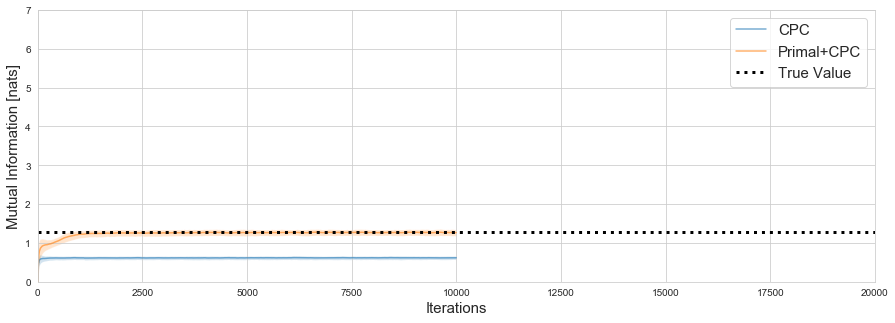

In [36]:
import seaborn as sns
sns.set_style("whitegrid")

f, ax = plt.subplots(1,1, figsize=(15,5))
n_average = 100

EMA_SPAN = 200

name_lookup={
    'ba': 'BA',
    'nwj': 'NWJ',
    'mine': 'MINE',
    'smile': 'SMILE',
    'psmile': 'Primal+SMILE',
    'js': 'DeepInfoMax',
    'pjs': 'Primal+DeepInfoMax',
    'pnwj': 'Primal+NWJ',
    'pmine': 'Primal+MINE',
    'pcpc': 'Primal+CPC',
    'cpc': 'CPC',
    'pd': 'Primal+Dual (ours)'
}

for name in results.estimator.unique():
    model_results = results[results["estimator"]==name]
    iterations = model_results["iteration"]
    values = model_results["value"].ewm(EMA_SPAN)

    mi_mean = values.mean()
    mi_std = values.std()
    #mi_std = ((values-mi_mean)**2)[:-n_average//2]**0.5
    # mi_mean = mi_mean[:-n_average//2]

    plt.plot(iterations, mi_mean, '-', alpha=0.6, label=name_lookup[name])
    plt.fill_between(iterations, mi_mean-mi_std, mi_mean+mi_std, alpha=0.2, zorder=-1)

plt.axhline(y=mi, color="k", linewidth=3, label='True Value', ls=':')
# plt.axhline(y=np.log(batch_size), color="k", ls='--', linewidth=1, label='$\\log\\ B$')
leg = plt.legend(fontsize=15)
for lh in leg.legendHandles:
    lh._legmarker.set_alpha(1)
plt.ylim(0, 7)
plt.xlim(0, 20000)
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Mutual Information [nats]", fontsize=15)
# sns.despine()

In [37]:
# PrimalMutualInformationEstimator.compute_ratio(mi_estimators["ba"], x,y.unsqueeze(1)), PrimalMutualInformationEstimator.compute_ratio(mi_estimators["pnwj"], x,y.unsqueeze(1)), NWJ.compute_ratio(mi_estimators["pnwj"], x,y.unsqueeze(1)), NWJ.compute_ratio(mi_estimators["nwj"], x,y.unsqueeze(1))

torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128, 2]) 0
torch.Size([128, 1]) torch.Size([128, 128]) torch.Size([128, 128

torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.Size([128, 1]) torch.Size([128, 32]) torch.Size([128, 32, 2]) 32
torch.

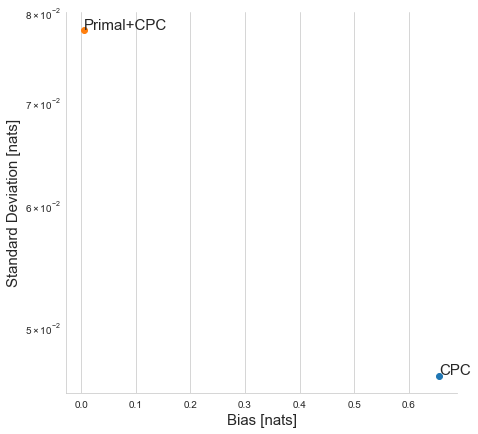

In [38]:

n_batches = 2000

f, ax = plt.subplots(1,1, figsize=(7,7))

offset = 0.0001
for name in results.estimator.unique():
    mi_values = []
    mi_estimator = mi_estimators[name]
    mi_estimator.eval()

    for _ in tqdm(range(n_batches)):
        batch_size = 128
        x, y = torch.chunk(p_xy.sample([batch_size]), 2, -1)
        x = x.squeeze()
        y = y.squeeze()

        mi_value, _ = mi_estimator(x,y)
        mi_values.append(mi_value.item())
    estimated_mi = np.mean(mi_values)
    bias = np.abs(estimated_mi-mi)
    std = np.std(mi_values)

    plt.plot(bias, std, 'o')
    plt.text(bias+offset, std+offset, name_lookup[name], fontsize=15)

# plt.xlim(0)
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("Bias [nats]", fontsize=15)
plt.ylabel("Standard Deviation [nats]", fontsize=15)
sns.despine()

In [39]:
res = 512
l = np.linspace(-5,5, res)
X, Y = np.meshgrid(l,l)
log_p_X = p_x.log_prob(torch.FloatTensor(l).unsqueeze(0).repeat(res,1).unsqueeze(-1)).sum(-1).data.numpy()
dist_results = []


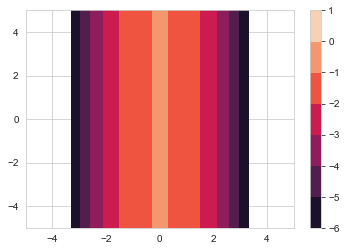

In [40]:
levels = np.linspace(-6,1, 8)
plt.contourf(X,Y, log_p_X/n_dim, levels=levels)
plt.colorbar()

# Barber-Agakov

In [41]:
estimator = mi_estimators['ba']
r_y_x = estimator.r_y_x

r_y_X = r_y_x.condition(torch.FloatTensor(l).unsqueeze(-1).repeat(1,n_dim))
r_Y_X = r_y_X.log_prob(torch.FloatTensor(l).unsqueeze(1).unsqueeze(-1).repeat(1,1,n_dim)).data.numpy()


dist_results.append({
    "estimator": "ba",
    "log r(y|x)": r_Y_X,
    "f(x,y)": r_Y_X*0,
    }
)


KeyError: 'ba'

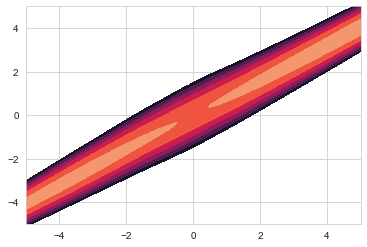

In [42]:
plt.contourf(X,Y, r_Y_X, levels=levels, extend="max")

# Dual

In [43]:
for name in [ "nwj", "mine", "js", "cpc", "smile"]:
    if name not in mi_estimators:
        continue
    estimator = mi_estimators[name]

    r_Y_X = p_x.log_prob(torch.FloatTensor(l).unsqueeze(0).repeat(res,1).unsqueeze(-1)).sum(-1).T
    f_X_Y = estimator.ratio_estimator(
        torch.Tensor(l).unsqueeze(-1).repeat(1, n_dim),
        torch.Tensor(l).unsqueeze(0).unsqueeze(-1).repeat(res, 1, n_dim)).T.squeeze()

    # if name == 'cpc':
    #     f_X_Y -= torch.logsumexp(f_X_Y, -1).unsqueeze(-1)-2*np.log(res)

    dist_results.append({
        "estimator": name,
        "log r(y|x)": r_Y_X.data.numpy(),
        "f(x,y)": f_X_Y.data.numpy(),
        }
    )


In [44]:
torch.Tensor(l).unsqueeze(-1).repeat(1, n_dim).shape,torch.Tensor(l).unsqueeze(0).unsqueeze(-1).repeat(res, 1, n_dim).shape, f_X_Y.shape

(torch.Size([512, 2]), torch.Size([512, 512, 2]), torch.Size([512, 512]))

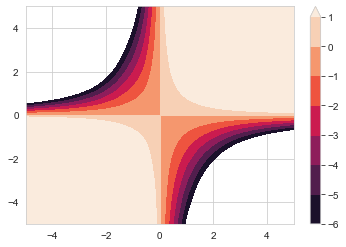

In [45]:
plt.contourf(X,Y, f_X_Y.data.numpy(), extend="max", levels=levels)
plt.colorbar()

# Primal+Dual

In [46]:
for name in ["pnwj", "pmine", "psmile", "pjs", "pcpc"]:
    if name not in mi_estimators:
        continue
    estimator = mi_estimators[name]

    r_Y_X = estimator.r_y_x.condition(torch.FloatTensor(l).unsqueeze(-1).repeat(1,n_dim)).log_prob(
        torch.FloatTensor(l).unsqueeze(1).unsqueeze(-1).repeat(1,1,n_dim)
    ).data

    f_X_Y = estimator.ratio_estimator(
        torch.Tensor(l).unsqueeze(-1).repeat(1, n_dim),
        torch.Tensor(l).unsqueeze(0).unsqueeze(-1).repeat(res, 1, n_dim)).T.squeeze()

    dist_results.append({
        "estimator": name,
        "log r(y|x)": r_Y_X.data.numpy(),
        "f(x,y)": f_X_Y.data.numpy(),
        }
    )


In [47]:
# estimator = mi_estimators[name]
#
# r_X_Y = Normal(0,1).log_prob(torch.FloatTensor(l)).unsqueeze(0).repeat(res,1)
# f_X_Y = estimator.ratio_estimator(
#     torch.Tensor(l).unsqueeze(-1).repeat(1, n_dim),
#     torch.Tensor(l).unsqueeze(0).unsqueeze(-1).repeat(res, 1, n_dim)).squeeze()
#
# # q_x_y = estimator.r_x_y
# #
# # q_x_Y = q_x_y.condition(torch.FloatTensor(l).unsqueeze(-1).repeat(1,n_dim))
# # q_X_Y = q_x_Y.log_prob(torch.FloatTensor(l).unsqueeze(1).unsqueeze(-1).repeat(1,1,n_dim)).data
#
# log_Z = torch.logsumexp((f_X_Y + r_X_Y), 0).mean()-np.log(res)
#
# dist_results.append({
#     "estimator": name,
#     "log r(x|y)": r_X_Y.data.numpy(),
#     "f(x,y) - log Z": (f_X_Y-log_Z).data.numpy(),
#     }
# )


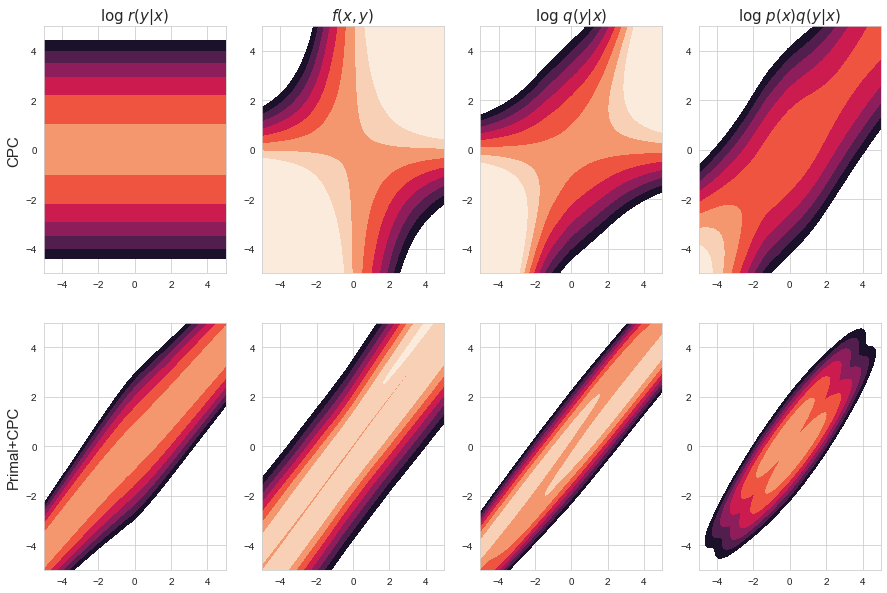

In [48]:
imgsize=5
f, ax = plt.subplots(len(dist_results), 4, figsize=(imgsize*3, imgsize*len(dist_results)))

if ax.ndim==1:
    ax = ax.reshape(1,-1)

ax[0,0].set_title("$\\log\\ r(y|x)$", fontsize=15)
ax[0,1].set_title("$f(x,y)$", fontsize=15)
ax[0,2].set_title("$\\log\\ q(y|x) $", fontsize=15)
ax[0,3].set_title("$\\log\\ p(x)q(y|x)$", fontsize=15)

levels = np.linspace(-10,2, 8)

for i, dist_result in enumerate(dist_results):
    log_r_Y_X = dist_result["log r(y|x)"]
    f = dist_result["f(x,y)"]
    # f_clamp = torch.clamp(torch.FloatTensor(dist_result["f(x,y)"]), -1000, 1000).data.numpy()

    log_Z_r = torch.logsumexp(torch.FloatTensor(log_r_Y_X + log_p_X).view(-1), 0).item()
    log_Z_q = torch.logsumexp(torch.FloatTensor(log_r_Y_X + f + log_p_X).reshape(-1), 0).item()

    ax[i,0].contourf(X, Y, (log_r_Y_X) / n_dim, levels=levels, extend="max")
    ax[i,1].contourf(X,Y, (f) / n_dim, levels=levels, extend="max")
    c = ax[i,2].contourf(X, Y, (f + log_r_Y_X) / n_dim, levels=levels, extend="max")
    ax[i,3].contourf(X, Y, (log_p_X + f + log_r_Y_X) / n_dim, levels=levels, extend="max")
    ax[i,0].set_ylabel(name_lookup[dist_result["estimator"]], fontsize=15)


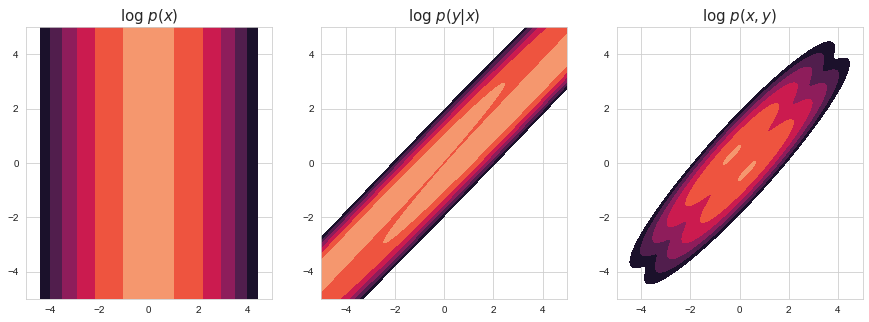

In [57]:
f, ax = plt.subplots(1,3, figsize=(3*imgsize, imgsize))

ax[0].set_title("$\\log\\ p(x) $", fontsize=15)
ax[1].set_title("$\\log\\ p(y|x) $", fontsize=15)
ax[2].set_title("$\\log\\ p(x,y) $", fontsize=15)


log_p_XY = p_xy.log_prob(torch.cat([
    torch.FloatTensor(X).view(-1,1),
    torch.FloatTensor(Y).view(-1,1),
], -1).unsqueeze(1).repeat(1,n_dim, 1)).sum(1).view(res,res).data.numpy()

# log_Z_X = torch.logsumexp(log_p_X.reshape(-1), -1)
# log_Z_XY = torch.logsumexp(log_p_XY.view(-1), -1)

ax[0].contourf(X,Y, log_p_X/n_dim, levels=levels)
ax[1].contourf(X,Y, (log_p_XY-log_p_X)/n_dim, levels=levels)
ax[2].contourf(X,Y, log_p_XY/n_dim, levels=levels)

In [122]:
log_p_X

tensor([[-25.2170, -25.2170, -25.2170,  ..., -25.2170, -25.2170, -25.2170],
        [-25.0323, -25.0323, -25.0323,  ..., -25.0323, -25.0323, -25.0323],
        [-24.8484, -24.8484, -24.8484,  ..., -24.8484, -24.8484, -24.8484],
        ...,
        [-24.8484, -24.8484, -24.8484,  ..., -24.8484, -24.8484, -24.8484],
        [-25.0323, -25.0323, -25.0323,  ..., -25.0323, -25.0323, -25.0323],
        [-25.2170, -25.2170, -25.2170,  ..., -25.2170, -25.2170, -25.2170]])

In [75]:
x, y = torch.chunk(p_xy.sample([1000000]), 2, -1)
x = x.squeeze()
y = y.squeeze()

x_ = mi_estimators["pnwj"].sample_negatives(x,y.unsqueeze(1))
#
# plt.plot(x[:,0], y[:,0], '.', label='p(x|y)', alpha=0.1)
# plt.plot(x_[:,0,0], y[:,0], '.', label='r(x|y)', alpha=0.1)
# plt.legend(fontsize=15)

AttributeError: 'PNWJ' object has no attribute 'sample_negatives'

In [ ]:
m = -4
M = 4
res = 32
X, Y = np.meshgrid(np.linspace(m,M, res),np.linspace(m,M, res))
density, _, _ = np.histogram2d(x[:,0].data.numpy(), y[:,0].data.numpy(), range=[[m,M],[m,M]], bins=res)
density_2, _, _ = np.histogram2d(x_[:,0,0].data.numpy(), y[:,0].data.numpy(), range=[[m,M],[m,M]], bins=res)

f_ = mi_estimators["pnwj"].ratio_estimator(
    torch.linspace(m,M,res).unsqueeze(-1).repeat(1,n_dim),
    torch.linspace(m,M,res).unsqueeze(0).unsqueeze(-1).repeat(res,1,n_dim)).squeeze().data.numpy()

log_Z = (mi_estimators["pnwj"].ratio_estimator(x_[:2048],y[:2048].unsqueeze(1))-1).exp().mean().item()

fig, ax = plt.subplots(1,4,figsize=(20,5))
ax[0].contourf(X,Y, density)
ax[1].contourf(X,Y, density_2)
c = ax[2].contourf(X,Y, density/density_2, levels=[0,0.9,1.1,2])
c = ax[3].contourf(X,Y, f_+log_Z, levels=[0,0.9,1.1,2])

ax[0].set_title("$p(x,y)$", fontsize=15)
ax[1].set_title("$r(x|y)p(y)$", fontsize=15)
ax[2].set_title("$p(x|y)/r(x|y)$", fontsize=15)
ax[3].set_title("$f(x,y)+\\log Z$", fontsize=15)

fig.colorbar(c, ax=ax[3])


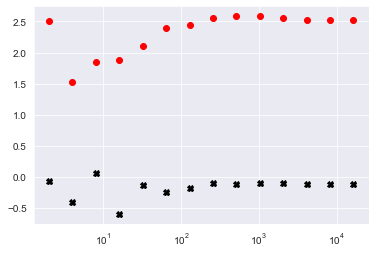

In [32]:
for i in range(1,15):
    s_x = x[:2**i]
    s_y = y[:2**i].unsqueeze(1)
    s_x_ = mi_estimators["pnwj"].sample_negatives(s_x,s_y)
    f_ = mi_estimators["pnwj"].ratio_estimator(s_x_,s_y)
    f = mi_estimators["pnwj"].ratio_estimator(s_x,s_y)
    b = mi_estimators["pnwj"].baseline(f_, y).unsqueeze(1)
    n = torch.FloatTensor(f).mean() - (f_-1).exp().mean()
    n_,_ = NWJ.forward(mi_estimators["pnwj"], s_x, s_y)


    plt.plot(2**i, n.item(), 'Xk')
    plt.plot(2**i, n_.item(), 'or')

plt.xscale("log")

In [23]:
f_.shape, s_x.shape, s_y.shape, s_x_.shape,

(torch.Size([16384, 1, 1]),
 torch.Size([16384, 2]),
 torch.Size([16384, 1, 2]),
 torch.Size([16384, 1, 2]))

In [26]:
.shape

torch.Size([16384, 1])

(tensor(1.1730, grad_fn=<MeanBackward0>),
 tensor(1.3298, grad_fn=<MeanBackward0>))

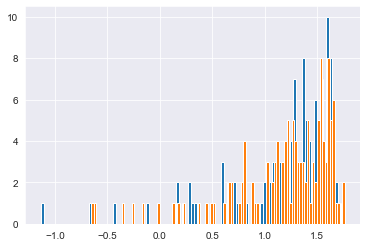

In [50]:
f = mi_estimators['pnwj'].ratio_estimator(x,y.unsqueeze(1))
f_ = mi_estimators['pnwj'].ratio_estimator(x_,y.unsqueeze(1))


plt.hist(f.view(-1).data, bins=100);
plt.hist(f_.view(-1).data, bins=100);

f.mean(), (f_-1).exp().mean()

In [102]:
mi_estimator = mi_estimators["smile"]
mi_estimator.eval()

mi_values = []
for _ in tqdm(range(n_batches)):
    batch_size = 128
    x, y = torch.chunk(p_xy.sample([batch_size]), 2, -1)
    x = x.squeeze()
    y = y.squeeze()
    for tau in np.linspace(0, 10, 10):
        mi_estimator.tau=tau
        mi_value, _ = mi_estimator(x,y)
        mi_values.append(
            {
                "value": mi_value.item(),
                "tau": tau
            })



KeyError: 'smile'

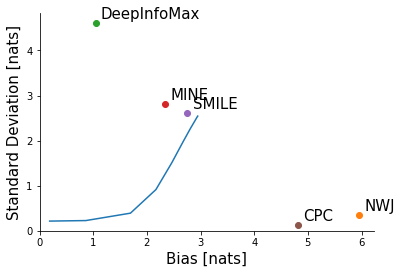

In [81]:
smile_values = pd.DataFrame(mi_values).groupby(["tau"]).aggregate(['mean','std']).reset_index()
plt.plot(np.abs(smile_values["value","mean"].values-mi),smile_values["value","std"].values)


for name in results.estimator.unique():
    mi_values = []
    mi_estimator = mi_estimators[name]
    mi_estimator.eval()

    for _ in tqdm(range(n_batches)):
        batch_size = 128
        x, y = torch.chunk(p_xy.sample([batch_size]), 2, -1)
        x = x.squeeze()
        y = y.squeeze()

        mi_value, _ = mi_estimator(x,y)
        mi_values.append(mi_value.item())
    estimated_mi = np.mean(mi_values)
    bias = np.abs(estimated_mi-mi)
    std = np.std(mi_values)

    plt.plot(bias, std, 'o')
    plt.text(bias+offset, std+offset, name_lookup[name], fontsize=15)

plt.xlim(0)
plt.ylim(0)
plt.xlabel("Bias [nats]", fontsize=15)
plt.ylabel("Standard Deviation [nats]", fontsize=15)
sns.despine()

plt.xlim(0)
plt.ylim(0)
plt.xlabel("Bias [nats]", fontsize=15)
plt.ylabel("Standard Deviation [nats]", fontsize=15)
sns.despine()

In [79]:
np.abs(smile_values["value","mean"]-mi)

0    0.187909
1    0.862464
2    1.693506
3    2.168220
4    2.464533
5    2.673230
6    2.811783
7    2.892598
8    2.930922
9    2.947360
Name: (value, mean), dtype: float64

In [12]:
mi_estimators['smile'].baseline

AttributeError: 'SMILE' object has no attribute 'baseline'

In [ ]:
y_ = mi_estimators['nwj'].sample_negatives(x,y)
plt.plot(y[0,0], y[0,1],'o')
plt.plot(y_[1,:,0], y_[1,:,1], '.')

In [ ]:
f_ = mi_estimators['cpc'].ratio_estimator(x,y_)
f = mi_estimators['cpc'].ratio_estimator(x,y)
a = mi_estimators['cpc'].baseline(f_,x)
f.shape, f_.shape

In [ ]:
import math
(torch.logsumexp(f_, 1)-np.log(x.shape[0])).mean(), a.mean(), mi_estimators['cpc'].compute_normalization(f_,x,y)

In [ ]:
plt.axhline(mi, color='k', ls='--')
    N = 10000
    values = np.nan_to_num(mi_values)
    # values[values > 100] = 100
    # values[values < -500] = -500

In [ ]:
consider_last = 10000
values[-consider_last:].mean(), values[-consider_last:].std(), mi

In [17]:
consider_last = 10000
values[-consider_last:].mean(), values[-consider_last:].std(), mi

(16.662906572914125, 0.3977542873183761, tensor(11.6395))

In [14]:
from core.distributions.utils import conditional_transformed_normal

x_dim = y_dim = 10
hidden_dims = [32, 32]

dist = conditional_transformed_normal(
    input_dim=x_dim,
    context_dim=y_dim,
    hidden_dims=hidden_dims,
)

In [15]:
mi_estimator.r_x_y.condition(torch.zeros(128, 10)).sample().shape

torch.Size([128, 10])